# **2110443 - Computer Vision (2022/2)**
#**Lab 9 - Modern Object Detection [Homework]** <br>
In this lab, we will learn how to use MMDetection to perform object detection in the provided real world dataset using PyTorch. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer.

**Collaboration is encouraged in this course.** You must turn in your own write ups of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- Taechit Phowthongbutr 6231324921
- ...


# Assignment 1 : Parasite Detection
![alt text](https://icip2022challenge.piclab.ai/wp-content/uploads/2022/01/parasite_egg_11_with_size.png) 

In this assignment you have to replace YOUR_STUDENT_ID_WITH21 variable with your student id (in integer). There will be 2 sets of data: train and test 

By using the knowledge from the lab and lecture, you have to train object detection model and tested on unknown label dataset!



Scoreboard URL : https://www.piclab.ai/classes/cv2022/lab9/scoreboard

Install prerequisite libraries for MMDetection


In [1]:
!pip install openmim
!mim install mmdet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 3.0 MB/s eta 0:00:00
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 19.5 MB/s eta 0:00:00
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  wa

In [3]:
import random
import glob
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import font_manager

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


##### Don't forget to put your ID here (in integer) ####
YOUR_STUDENT_ID_WITH21 = 6230314421 
#######################################################

def isStudentIDValid(studentID):
  strID = str(studentID)
  isEndWith21 = strID.endswith('21')
  isLengthOK = len(strID) == 10
  if isEndWith21 and isLengthOK:
    return True
  else:
    return False

print('Student ID status:',isStudentIDValid(YOUR_STUDENT_ID_WITH21))

Student ID status: True


## Your model description goes here: ###
We use ssd300 model and ssd300_coco config file. <br>
Pretrained weights ssd300_coco_20210803_015428-d231a06e.pth <br>
Train 5 epochs with lr = 1e-3

## GPU Status Check

In [4]:
!nvidia-smi

Sat Apr  1 14:45:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and inspect parasite dataset

In [5]:
!pip install --upgrade gdown 
!gdown https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF
!gdown https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3
!unzip parasite_train.zip
!unzip parasite_test.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF
From (redirected): https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF&confirm=t&uuid=b0143f0d-bf34-4bfd-b7b4-5a7edb99bb82
To: /content/parasite_test.zip
100% 142M/142M [00:00<00:00, 224MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3
From (redirected): https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3&confirm=t&uuid=2ebf507b-8519-41ab-b9ee-9dea3f66348c
To: /content/parasite_train.zip
100% 715M/715M [00:03<00:00, 189MB/s]
Archive:  parasite_train.zip
   creating: parasite_train/
  inflating: parasite_train/labels.json  
   creating: parasite_train/data/
  inflating: p

### Download Model


In [6]:
#### FILL YOUR CODE HERE ####
# !mim download mmdet --config mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco --dest .
!mim download mmdet --config ssd300_coco --dest .

/usr/local/lib/python3.9/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 MiB 35.9 MB/s eta 0:00:00
Successfully downloaded mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth to /content
Successfully dumped mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py to /content
/usr/local/lib/python3.9/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation mo

### Dataset Exploration
We will use pycocotools to explore this dataset. 

In [9]:
from mmcv import Config

modelConfig = Config.fromfile('ssd300_coco.py') 
print(f'Original Config:\n{modelConfig.pretty_text}')

Original Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    backbone=dict(
        type='SSDVGG',
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://vgg16_caffe')),
    neck=dict(
        type='SSDNeck',
        in_channels=(512, 1024),
        out_channels=(512, 1024, 512, 256, 256, 256),
        level_strides=(2, 2, 1, 1),
        level_paddings=(1, 1, 0, 0),
        l2_norm_scale=20),
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=80,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_co

In [10]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [11]:
trainLabelFile='parasite_train/labels.json'
# initialize COCO api for instance annotations
trainCOCOBinding = COCO(trainLabelFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


COCO categories: 
Capillaria philippinensis Enterobius vermicularis Hymenolepis diminuta Hymenolepis nana Paragonimus spp

Image Data >> {'id': 57, 'file_name': 'Hymenolepis nana_0281.jpg', 'height': 4032, 'width': 3024, 'license': None, 'coco_url': None}
Box Data [{'id': 57, 'image_id': 57, 'category_id': 3, 'bbox': [1315.0, 2203.0, 246.0, 251.0], 'area': 61746.0, 'iscrowd': 0}]


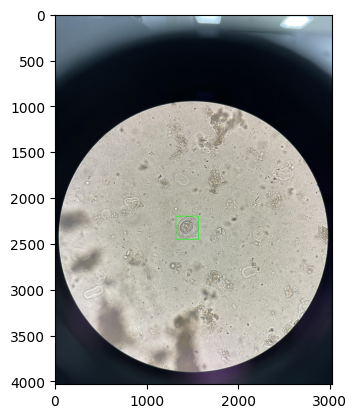

In [12]:
#display COCO categories and supercategories
cats = trainCOCOBinding.loadCats(trainCOCOBinding.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

# get all images containing given categories, select one at random
catIds = trainCOCOBinding.getCatIds(catNms=['Hymenolepis diminuta',]);
imgIds = trainCOCOBinding.getImgIds(catIds=catIds );

randomImgId = np.random.randint(0,len(imgIds))
sampleImageData = trainCOCOBinding.loadImgs(randomImgId)[0]

print('Image Data >>', sampleImageData)

sampleImage = cv2.imread('parasite_train/data/'+sampleImageData['file_name'])

annIds = trainCOCOBinding.getAnnIds(imgIds=randomImgId, iscrowd=None)
boxes = trainCOCOBinding.loadAnns(annIds)
print('Box Data', boxes)

for box in boxes:
  x,y,w,h = box['bbox']
  cv2.rectangle(sampleImage, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 5)

sampleImage = cv2.cvtColor(sampleImage, cv2.COLOR_BGR2RGB)

plt.imshow(sampleImage)
plt.show()

### Modify MMDetection model configuration

In [38]:
from mmcv.utils.config import ConfigDict
from mmdet.apis import set_random_seed

# Modify dataset type and path
#### FILL YOUR CODE HERE ####
# Modify dataset type and path
modelConfig.device = 'cuda'

modelConfig.dataset_type = 'CocoDataset'
modelConfig.data_root = '/content/parasite_train/data'
modelConfig.classes = ('Capillaria philippinensis', 'Enterobius vermicularis', 'Hymenolepis diminuta', 'Hymenolepis nana', 'Paragonimus spp')

modelConfig.model.bbox_head.num_classes = 5

modelConfig.data.train = ConfigDict()
modelConfig.data.train.pipeline = modelConfig.train_pipeline
modelConfig.data.train.type = 'CocoDataset'
modelConfig.data.train.classes = modelConfig.classes
modelConfig.data.train.data_root = modelConfig.data_root
modelConfig.data.train.ann_file = '/content/parasite_train/labels.json'
modelConfig.data.train.img_prefix = ''

modelConfig.data.val = ConfigDict()
modelConfig.data.val.pipeline = modelConfig.test_pipeline
modelConfig.data.val.type = 'CocoDataset'
modelConfig.data.val.classes = modelConfig.classes
modelConfig.data.val.data_root = modelConfig.data_root
modelConfig.data.val.ann_file = '/content/parasite_train/labels.json'
modelConfig.data.val.img_prefix = ''


modelConfig.data.test = ConfigDict()
modelConfig.data.test.pipeline = modelConfig.test_pipeline
modelConfig.data.test.type = 'CocoDataset'
modelConfig.data.test.classes = modelConfig.classes
modelConfig.data.test.data_root = modelConfig.data_root
modelConfig.data.test.ann_file = '/content/parasite_train/labels.json'
modelConfig.data.test.img_prefix = ''


# Set up working dir to save files and logs.
modelConfig.work_dir = './'
# use pretrained model as start point
modelConfig.load_from = 'ssd300_coco_20210803_015428-d231a06e.pth'

modelConfig.optimizer.lr = 1e-3
modelConfig.lr_config.warmup = None
modelConfig.lr_config.policy = 'step'
modelConfig.lr_config.step = [10,25]
modelConfig.log_config.interval = 10

# Evaluation interval
modelConfig.evaluation.interval = 5
# Checkpoint saving interval
modelConfig.checkpoint_config.interval = 5
modelConfig.runner.max_epochs = 5

# Set seed thus the results are more reproducible
modelConfig.seed = 0
set_random_seed(0, deterministic=False)
modelConfig.gpu_ids = range(1)


print(f'Modified Config:\n{modelConfig.pretty_text}')

Modified Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    backbone=dict(
        type='SSDVGG',
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        init_cfg=None),
    neck=dict(
        type='SSDNeck',
        in_channels=(512, 1024),
        out_channels=(512, 1024, 512, 256, 256, 256),
        level_strides=(2, 2, 1, 1),
        level_paddings=(1, 1, 0, 0),
        l2_norm_scale=20),
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=5,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_mean

### Training

In [16]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import mmcv
import os

# Build dataset
datasets = [build_dataset(modelConfig.data.train)]

# Build the detecmodelConfig, distributed=False, validate=True)tor
model = build_detector(modelConfig.model, train_cfg=modelConfig.get('train_cfg'), test_cfg=modelConfig.get('test_cfg'))

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(modelConfig.work_dir))
train_detector(model, datasets, modelConfig, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2023-04-01 14:57:23,608 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-04-01 14:57:23,628 - mmdet - INFO - load checkpoint from local path: ssd300_coco_20210803_015428-d231a06e.pth
2023-04-01 14:57:23,745 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.cls_convs.0.0.weight: copying a param with shape torch.Size([324, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 512, 3, 3]).
size mismatch for bbox_head.cls_convs.0.0.bias: copying a param with shape torch.Size([324]) from checkpoint, the shape in current model is torch.Size([24]).
size mismatch for bbox_head.cls_convs.1.0.weight: copying a param with shape torch.Size([486, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([36, 1024, 3, 3]).
size mismatch for bbox_head.cls_convs.1.0.bias: copying a param with shape torch.Size([486]) from checkpoint, the shape in current model is torch.Size([36]).
size 

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2023-04-01 14:57:47,677 - mmdet - INFO - Epoch [1][10/126]	lr: 1.000e-03, eta: 0:24:32, time: 2.375, data_time: 2.076, memory: 1892, loss_cls: 8.2065, loss_bbox: 1.2998, loss: 9.5063
2023-04-01 14:58:09,716 - mmdet - INFO - Epoch [1][20/126]	lr: 1.000e-03, eta: 0:23:16, time: 2.204, data_time: 1.890, memory: 1892, loss_cls: 6.2329, loss_bbox: 1.1289, loss: 7.3618
2023-04-01 14:58:25,016 - mmdet - INFO - Epoch [1][30/126]	lr: 1.000e-03, eta: 0:20:21, time: 1.530, data_time: 1.216, memory: 1892, loss_cls: 4.6585, loss_bbox: 0.6921, loss: 5.3506
2023-04-01 14:58:50,594 - mmdet - INFO - Epoch [1][40/126]	lr: 1.000e-03, eta: 0:21:18, time: 2.558, data_time: 2.228, memory: 1892, loss_cls: 4.2892, loss_bbox: 0.9488, loss: 5.2380
2023-04-01 14:59:26,270 - mmdet - INFO - Epoch [1][50/126]	lr: 1.000e-03, eta: 0:23:39, time: 3.566, data_time: 3.263, memory: 1892, loss_cls: 3.9575, loss_bbox: 1.0914, loss: 5.0489
2023-04-01 14:59:38,641 - mmdet - INFO - Epoch [1][60/126]	lr: 1.000e-03, eta: 0:21:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 11.6 task/s, elapsed: 86s, ETA:     0s

2023-04-01 15:20:19,997 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.37s).
Accumulating evaluation results...


2023-04-01 15:20:26,017 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.883
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.796
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=10

DONE (t=1.35s).


### Inference on test set!

In [17]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

In [18]:
def get_coco_result(bboxes, id, score_thr, file_name):
    coco_results = []
    for i in range(len(bboxes)):
        # print(bboxes[i])
        if len(bboxes[i])> 0 and bboxes[i][:, 4].max() > score_thr:
            x1, y1, x2, y2 = bboxes[i][0, :4].tolist()
            width = x2 - x1
            height = y2 - y1
            x = x1
            y = y1
            score = float(bboxes[i][0, 4])
            coco_result = {
                'id': id,
                'category_id': i,  # COCO dataset class IDs start from 1
                'bbox': [x, y, width, height],
                'score': score,
                'file_name': file_name
            }
            
         
            id += 1
            coco_results.append(coco_result)
    return coco_results, id

In [39]:
model = init_detector(modelConfig, 'latest.pth')
model.cfg = modelConfig

load checkpoint from local path: latest.pth


/usr/local/lib/python3.9/dist-packages/mmdet/apis/inference.py:51: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


### Submit Results

In [40]:
from mmdet.core import  bbox2result

image_dir = '/content/parasite_test/data'

annotations = dict()
annotations['annotations'] = list()
id = 0
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)
        
        result = inference_detector(model, image_path)
        # print(result)
        coco_result, id = get_coco_result(result, id, 0.3,filename)
        annotations['annotations']+=coco_result
        # break

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


In [41]:
import requests
sendDict = { 'studentID':YOUR_STUDENT_ID_WITH21, 'results':  annotations }
response = requests.post('https://www.piclab.ai/classes/cv2022/lab9/scoreboard/submitLab9',headers={'Content-Type': 'application/json' }, json=sendDict)
print(response.text)

{"F1Score":0.7959865190468731,"mAP0.5":0.7428046499231203,"mAP0.5:0.95":0.5425053314138507,"mAP0.75":0.6759260526279987,"mIoU":0.6081028855194062,"status":"SUCCESS"}



In [43]:
annotations['annotations'][0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'id': 0,
 'category_id': 2,
 'bbox': [1332.1556396484375,
  1889.533447265625,
  324.6932373046875,
  308.53271484375],
 'score': 0.9393766522407532,
 'file_name': 'Hymenolepis diminuta_0052.jpg'}